In [1]:
import numpy as np
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset
from UCM import UCM

In [2]:
from test_utils import compute_log_likelihood_importance_sampling, compute_log_likelihood_monte_carlo, \
                        model_test_loss, log_mean_exp
from train_utils import train_model
from losses import gaussian_loss
from mask_generators import generate_bernoulli

In [3]:
def generate_bernoulli_2d(batch_size):
    return generate_bernoulli(batch_size, 2)

In [4]:
np.random.seed(123)

In [5]:
m = torch.tensor([[2, 2], [-2, -2]]).float()
data = torch.randn(10000, 2) * 0.1 + m[np.random.choice(2, 10000)]
train_data = TensorDataset(data[:7000])
test_data = TensorDataset(data[7000:])

In [6]:
class UM(nn.Module):
    def __init__(self, loss, network):
        super(type(self), self).__init__()
        self.loss = loss
        self.network = network

    def batch_loss(self, batch, weights=None, K=1):
        res = 0
        for i in range(K):
            x, b = batch
            b = b * torch.bernoulli(torch.ones_like(b).cuda() * torch.rand(b.size(0), 1).cuda()).cuda()
            x, b = Variable(x), Variable(b)
            data = torch.cat([x * (1 - b), b], 1)
            x_distr = self.network(data)
            res += self.loss(x, x_distr, b).mean() / K
        return res

    def generate_samples(self, x, b, K):
        n, d = x.shape
        x = x * (1 - b)
        x = x.view(n, 1, d).repeat(1, K, 1).view(-1, d)
        b = b.view(n, 1, d).repeat(1, K, 1).view(-1, d)
        while (b.sum() != 0):
            data = torch.cat([x, b], 1)
            x_distr = self.network(Variable(data)).data
            b_sum = b.sum(1, True)
            i_idx = torch.nonzero(b_sum)[:, 0]
            j_idx = torch.multinomial(b[i_idx] / b_sum[i_idx], 1).view(-1)
            mu = x_distr[i_idx, j_idx]
            sigma = x_distr[i_idx, j_idx + d]
            sigma = nn.functional.softplus(sigma)
            x[i_idx, j_idx] = mu + torch.randn(*mu.shape) * sigma
            b[i_idx, j_idx] = 0
        return x.view(n, K, d)

In [7]:
network = nn.Sequential(
    nn.Linear(4, 16),
    nn.LeakyReLU(inplace=True),
    nn.Linear(16, 64),
    nn.LeakyReLU(),
    nn.Linear(64, 16),
    nn.LeakyReLU(),
    nn.Linear(16, 4),
)
prior_network = nn.Sequential(
    nn.Linear(4, 16),
    nn.LeakyReLU(inplace=True),
)
prior_mu_head = nn.Linear(16, 64)
prior_sigma_head = nn.Linear(16, 64)
proposal_network = nn.Sequential(
    nn.Linear(4, 16),
    nn.LeakyReLU(inplace=True),
)
proposal_mu_head = nn.Linear(16, 64)
proposal_sigma_head = nn.Linear(16, 64)
generative_network = nn.Sequential(
    nn.Linear(64, 16),
    nn.LeakyReLU(inplace=True),
    nn.Linear(16, 4),
)

In [8]:
model = UM(gaussian_loss, network)

In [9]:
%time model_um = train_model(train_data, model, generate_bernoulli_2d, \
                             batch_size=200, num_epochs=30, learning_rate=1e-3)

Epoch 0 Train loss -3.0614311695098877 Batch 35 of 35           
Epoch 1 Train loss -3.0728724002838135 Batch 35 of 35           
Epoch 2 Train loss -2.4823501110076904 Batch 35 of 35           
Epoch 3 Train loss -2.4006645679473877 Batch 35 of 35           
Epoch 4 Train loss -1.6981271505355835 Batch 35 of 35           
Epoch 5 Train loss -1.6606236696243286 Batch 35 of 35           
Epoch 6 Train loss -2.0377750396728516 Batch 35 of 35           
Epoch 7 Train loss -1.80861496925354 Batch 35 of 35            
Epoch 8 Train loss -1.175489068031311 Batch 35 of 35           
Epoch 9 Train loss -1.8115174770355225 Batch 35 of 35           
Epoch 10 Train loss -1.7106624841690063 Batch 35 of 35           
Epoch 11 Train loss -1.591077446937561 Batch 35 of 35           
Epoch 12 Train loss -1.7320088148117065 Batch 35 of 35           
Epoch 13 Train loss -1.9419119358062744 Batch 35 of 35           
Epoch 14 Train loss -1.8209439516067505 Batch 35 of 35           
Epoch 15 Train loss -1.

In [10]:
def chain_rule_log_likelihood_estimation(model, x_true, b, K=1):
    n, d = b.shape
    x_true = x_true.view(n, 1, d).repeat(1, K, 1).view(-1, d)
    b = b.view(n, 1, d).repeat(1, K, 1).view(-1, d)
    res = torch.zeros(b.size(0)).cuda()
    while (b.sum() != 0):
        data = torch.cat([x_true * (1 - b), b], 1)
        x_distr = model.network(Variable(data)).data
        b_sum = b.sum(1, True)
        i_idx = torch.nonzero(b_sum)[:, 0]
        j_idx = torch.multinomial(b[i_idx] / b_sum[i_idx], 1).view(-1)
        add = gaussian_loss(
            x_true[i_idx, j_idx].view(-1, 1),
            x_distr[i_idx, j_idx].view(-1, 1), torch.ones(i_idx.shape[0], 1).cuda())[:, 0]
        res[i_idx] += add
        b[i_idx, j_idx] = 0
    return float(log_mean_exp(res.view(-1, K)).mean())

In [11]:
model_um['model'].cuda()
%time print(model_test_loss(test_data, generate_bernoulli_2d, \
                            lambda batch, b: \
                            chain_rule_log_likelihood_estimation(model_um['model'], batch, b, K=100), \
                            max_batches=5, batch_size=1, is_cuda=True))
model_um['model'].cpu()
pass

-5.8854570388793945
CPU times: user 20.2 ms, sys: 0 ns, total: 20.2 ms
Wall time: 19.9 ms


In [12]:
model = UCM(1, gaussian_loss,
        proposal_network, proposal_mu_head, proposal_sigma_head,
        prior_network, prior_mu_head, prior_sigma_head,
        generative_network)

In [13]:
%time model_ucm = train_model(train_data, model, generate_bernoulli_2d, \
                              batch_size=200, num_epochs=30, learning_rate=1e-2)

Epoch 0 Train loss -5.60271692276001 Batch 35 of 35            
Epoch 1 Train loss -5.540275573730469 Batch 35 of 35           
Epoch 2 Train loss -4.997217655181885 Batch 35 of 35           
Epoch 3 Train loss -5.017531394958496 Batch 35 of 35           
Epoch 4 Train loss -4.921475410461426 Batch 35 of 35           
Epoch 5 Train loss -4.8700175285339355 Batch 35 of 35           
Epoch 6 Train loss -4.447007656097412 Batch 35 of 35           
Epoch 7 Train loss -4.293051242828369 Batch 35 of 35           
Epoch 8 Train loss -4.662258148193359 Batch 35 of 35           
Epoch 9 Train loss -3.6239335536956787 Batch 35 of 35           
Epoch 10 Train loss -2.9268455505371094 Batch 35 of 35           
Epoch 11 Train loss -2.396019458770752 Batch 35 of 35           
Epoch 12 Train loss -1.8398932218551636 Batch 35 of 35           
Epoch 13 Train loss -1.8562535047531128 Batch 35 of 35           
Epoch 14 Train loss -1.568060040473938 Batch 35 of 35           
Epoch 15 Train loss -1.4302009

In [14]:
def average(func, K=5):
    res = []
    for i in range(K):
        res.append(func())
    res = torch.Tensor(res)
    return res.mean(), res.std()

In [15]:
is_100 = lambda: \
    model_test_loss(test_data, generate_bernoulli_2d,
                    lambda batch, b:    compute_log_likelihood_importance_sampling(batch, b,
                                                                                   model_ucm['model'].cuda(),
                                                                                   gaussian_loss, K=100),
                    is_cuda=True,
                    max_batches=30)

In [16]:
%time print('%f \pm %f' % average(is_100))

-1.084287 \pm 0.003568
CPU times: user 8.88 s, sys: 34.4 ms, total: 8.91 s
Wall time: 8.91 s


In [17]:
from matplotlib import pyplot as plt
%matplotlib inline

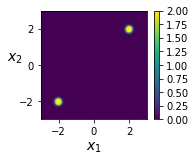

In [18]:
plt.figure(figsize=(4.75 / 2, 4. / 2))

x0, y0 = np.arange(-3.0, 3.000001, 0.05), np.arange(-3.0, 3.00001, 0.05)
x, y = np.meshgrid(x0, y0)
d1 = x[:, :, np.newaxis] - m.numpy()[np.newaxis, np.newaxis, :, 0]
d2 = y[:, :, np.newaxis] - m.numpy()[np.newaxis, np.newaxis, :, 1]
d = d1 ** 2 + d2 ** 2
f = np.log(1 / 2 / np.pi / 0.01) - d / 2 / (0.1**2)
maxf = f.max(axis=2)[:, :, np.newaxis]
f = np.log(np.exp(f - maxf).mean(axis=2)) + maxf[:, :, 0]
f = np.exp(f)
plt.pcolormesh(x, y, f, vmax=2, shading='gouraud')
plt.colorbar()
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', rotation=0, fontsize=14)
plt.xlim(-3.0, 3.0)
plt.ylim(-3.0, 3.0)
plt.savefig('gaussians_true_00.pdf', bbox_inches='tight')

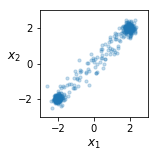

In [19]:
plt.figure(figsize=(2, 2))

plt.xlabel('$x_1$', fontsize=12)
plt.ylabel('$x_2$', rotation=0, fontsize=12)
model_ucm['model'].cpu()
p = model_ucm['model'].generate_samples(torch.zeros(500, 2), torch.ones(500, 2), 1).view(-1, 4)
mu = p[:, :2]
sigma = p[:, 2:]
sigma = nn.functional.softplus(sigma)
p = mu + torch.randn(*mu.shape) * sigma
plt.xlim(-3.0, 3.0)
plt.ylim(-3.0, 3.0)
plt.scatter(p[:, 0], p[:, 1], alpha=0.25, s=10)
plt.tight_layout(pad=0, w_pad=0.5, h_pad=0.5)
plt.savefig('gaussian_ucm.pdf', bbox_inches='tight')

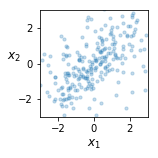

In [20]:
plt.figure(figsize=(2, 2))

plt.xlabel('$x_1$', fontsize=12)
plt.ylabel('$x_2$', rotation=0, fontsize=12)
model_um['model'].cpu()
p = model_um['model'].generate_samples(torch.zeros(500, 2), torch.ones(500, 2), 1).view(-1, 4)
mu = p[:, :2]
sigma = p[:, 2:]
sigma = nn.functional.softplus(sigma)
p = mu + torch.randn(*mu.shape) * sigma
plt.xlim(-3.0, 3.0)
plt.ylim(-3.0, 3.0)
plt.scatter(p[:, 0], p[:, 1], alpha=0.25, s=10)
plt.tight_layout(pad=0, w_pad=0.5, h_pad=0.5)
plt.savefig('gaussian_um.pdf', bbox_inches='tight')